# Consumo de Cerveja (São Paulo)

Objetivo: **responder perguntas investigativas com evidências** (gráficos + números) usando o dataset `Consumo_cerveja.csv`.

**Perguntas que vamos responder**
1. Existe relação entre **temperatura média** e **consumo**?
2. O consumo é diferente em **fim de semana** vs **dia útil**?
3. Chuva (precipitação) afeta o consumo?
4. Existe **sazonalidade** (variação por mês) no consumo?


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


## 0) Carregamento e limpeza mínima


In [36]:
DATA_PATH = "Consumo_cerveja.csv"  # se estiver na mesma pasta do notebook

raw = pd.read_csv(DATA_PATH)

# Data
raw["Data"] = pd.to_datetime(raw["Data"], errors="coerce")

# Numéricas (aceita tanto '.' quanto ',' como separador decimal)
num_cols = [
    "Temperatura Media (C)",
    "Temperatura Minima (C)",
    "Temperatura Maxima (C)",
    "Precipitacao (mm)",
    "Final de Semana",
    "Consumo de cerveja (litros)",
]

for col in num_cols:
    raw[col] = (
        raw[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .replace("nan", np.nan)
    )
    raw[col] = pd.to_numeric(raw[col], errors="coerce")

# Remove linhas vazias
before = raw.shape[0]
df = raw.dropna(subset=["Data", "Consumo de cerveja (litros)"]).copy()
after = df.shape[0]

print(f"Linhas antes: {before} | depois: {after} | removidas: {before-after}")
print("Período:", df["Data"].min().date(), "→", df["Data"].max().date())

df.head()

Linhas antes: 941 | depois: 365 | removidas: 576
Período: 2015-01-01 → 2015-12-31


,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
0,2015-01-01,27.30,23.9,32.5,0.0,0.0,25.461
1,2015-01-02,27.02,24.5,33.5,0.0,0.0,28.972
2,2015-01-03,24.82,22.4,29.9,0.0,1.0,30.814
3,2015-01-04,23.98,21.5,28.6,1.2,1.0,29.799
4,2015-01-05,23.82,21.0,28.3,0.0,0.0,28.900


## 1) Temperatura média vs consumo

**Pergunta:** quando a temperatura média aumenta, o consumo também tende a aumentar?

**Evidências:**
- Gráfico de dispersão + linha de tendência.
- Correlação de Pearson (r) e p-valor.


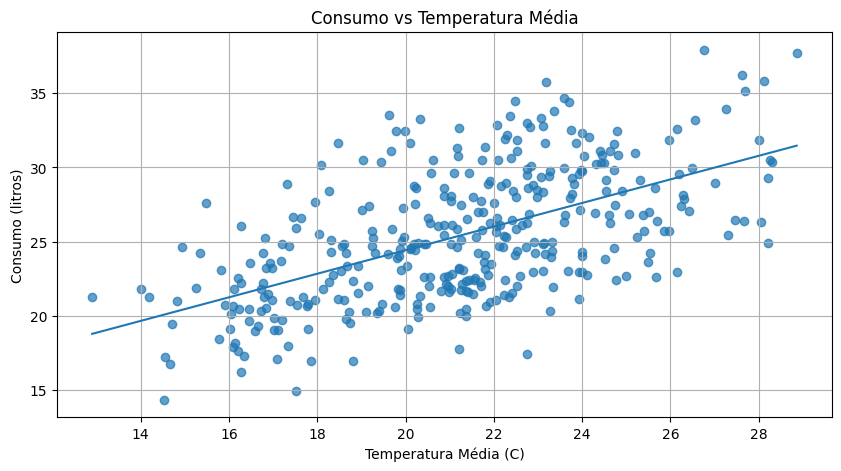

In [37]:
x = df["Temperatura Media (C)"]
y = df["Consumo de cerveja (litros)"]

# Correlação de Pearson
mask = x.notna() & y.notna()
r, p = stats.pearsonr(x[mask], y[mask])

# Dispersão + tendência
plt.figure()
plt.scatter(x, y, alpha=0.7)
coef = np.polyfit(x[mask], y[mask], 1)
x_line = np.linspace(x[mask].min(), x[mask].max(), 100)
y_line = coef[0] * x_line + coef[1]
plt.plot(x_line, y_line)
plt.title("Consumo vs Temperatura Média")
plt.xlabel("Temperatura Média (C)")
plt.ylabel("Consumo (litros)")
plt.show()

## 2) Fim de semana vs dia útil

**Pergunta:** o consumo em **fim de semana** é maior do que em dias úteis?

**Evidências:**
- Boxplot comparando as distribuições.
- Média por grupo + teste t de Welch (diferença de médias).


<Figure size 1000x500 with 0 Axes>

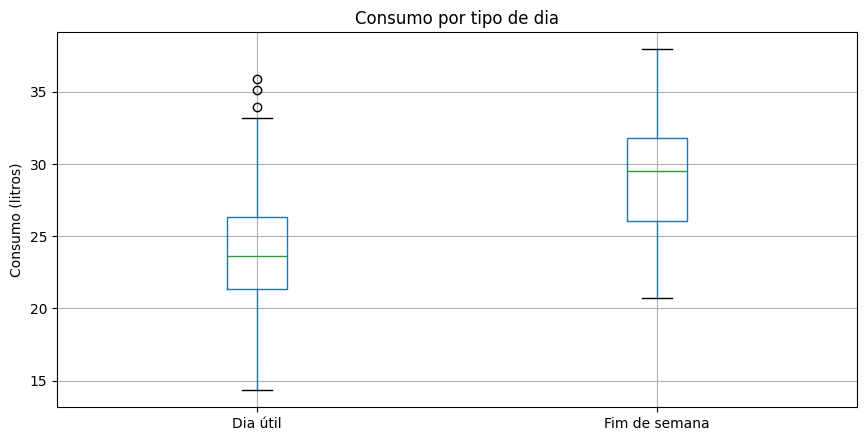

               count       mean       std
Tipo de dia                              
Dia útil         261  23.998222  3.787527
Fim de semana    104  28.922721  3.830191
Diferença de médias (fim de semana - dia útil) = 4.924 litros


In [38]:
df["Tipo de dia"] = np.where(df["Final de Semana"] == 1, "Fim de semana", "Dia útil")

plt.figure()
df.boxplot(column="Consumo de cerveja (litros)", by="Tipo de dia")
plt.title("Consumo por tipo de dia")
plt.suptitle("")
plt.xlabel("")
plt.ylabel("Consumo (litros)")
plt.show()

grp = df.groupby("Tipo de dia")["Consumo de cerveja (litros)"]
summary = grp.agg(["count", "mean", "std"]).sort_index()
print(summary)

# Teste t de Welch (variâncias podem ser diferentes)
w = df.loc[df["Tipo de dia"] == "Fim de semana", "Consumo de cerveja (litros)"].dropna()
d = df.loc[df["Tipo de dia"] == "Dia útil", "Consumo de cerveja (litros)"].dropna()

print(f"Diferença de médias (fim de semana - dia útil) = {w.mean() - d.mean():.3f} litros")

# Fim de semana tende a ter mais encontros/lazer, aumentando o consumo.

## 3) Chuva (precipitação) e consumo

**Pergunta:** em dias com chuva, o consumo muda?

**Evidências:**
- Boxplot: **Chuva** vs **Sem chuva**.
- Média por grupo + teste t de Welch.
- (Opcional) Dispersão precipitação vs consumo para enxergar tendência.


<Figure size 1000x500 with 0 Axes>

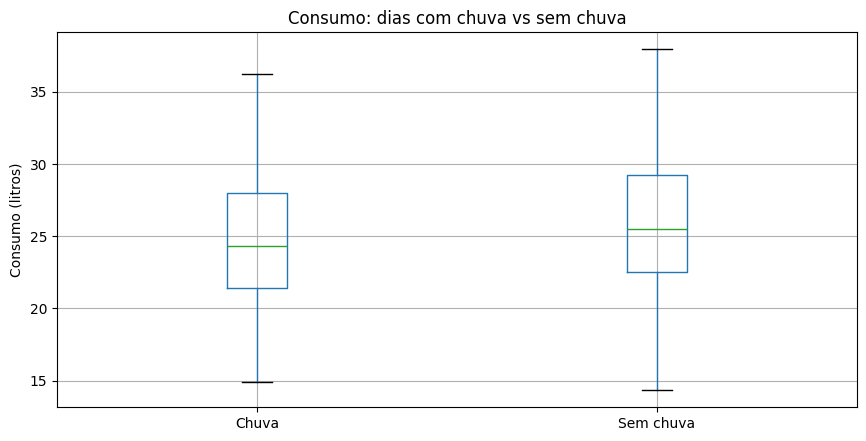

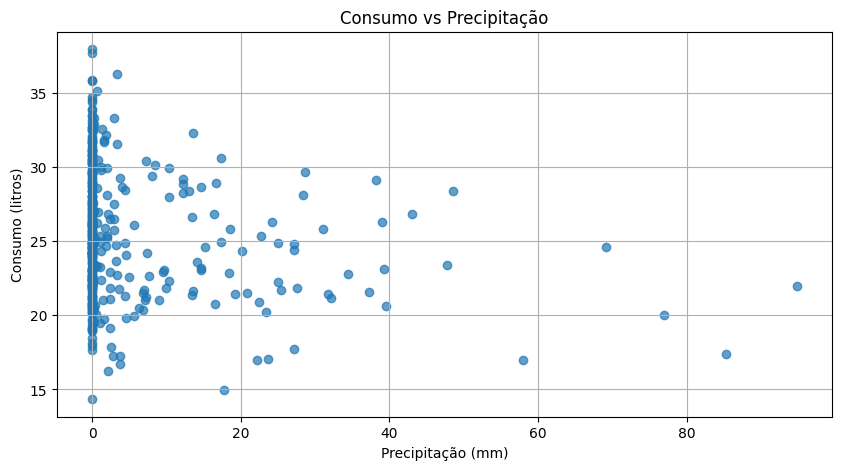

In [39]:
df["Tem chuva?"] = np.where(df["Precipitacao (mm)"].fillna(0) > 0, "Chuva", "Sem chuva")

plt.figure()
df.boxplot(column="Consumo de cerveja (litros)", by="Tem chuva?")
plt.title("Consumo: dias com chuva vs sem chuva")
plt.suptitle("")
plt.xlabel("")
plt.ylabel("Consumo (litros)")
plt.show()

# Dispersão precipitação vs consumo
plt.figure()
plt.scatter(df["Precipitacao (mm)"], df["Consumo de cerveja (litros)"], alpha=0.7)
plt.title("Consumo vs Precipitação")
plt.xlabel("Precipitação (mm)")
plt.ylabel("Consumo (litros)")
plt.show()

# Chuva não parece ser o principal fator para explicar o consumo.

## 4) Sazonalidade (média por mês)

**Pergunta:** o consumo médio muda conforme o mês do ano?

**Evidências:**
- Linha com a média mensal do consumo.
- Lista dos meses com maior/menor consumo médio.


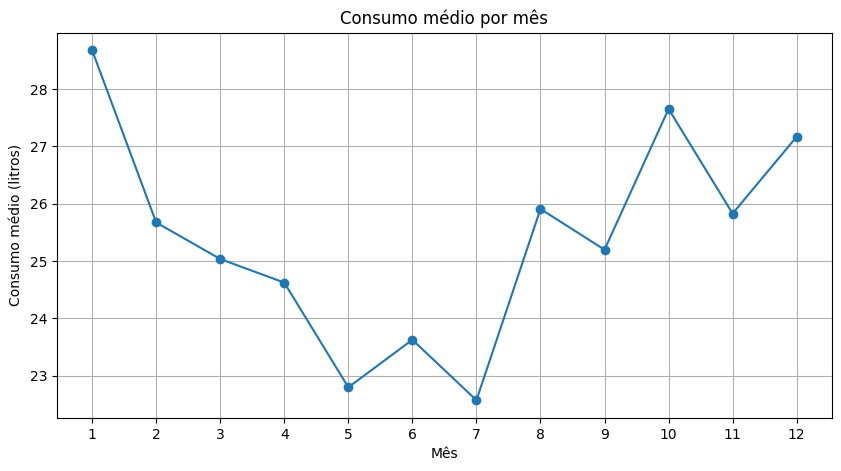

Top 3 meses (maior consumo):
Mes
1     28.677645
10    27.653194
12    27.169516
Name: Consumo de cerveja (litros), dtype: float64
Bottom 3 meses (menor consumo):
Mes
7    22.572871
5    22.798387
6    23.627067
Name: Consumo de cerveja (litros), dtype: float64


In [40]:
tmp = df.copy()
tmp["Mes"] = tmp["Data"].dt.month

consumo_mensal = tmp.groupby("Mes")["Consumo de cerveja (litros)"].mean().reindex(range(1, 13))

plt.figure()
plt.plot(consumo_mensal.index, consumo_mensal.values, marker="o")
plt.title("Consumo médio por mês")
plt.xlabel("Mês")
plt.ylabel("Consumo médio (litros)")
plt.xticks(range(1, 13))
plt.show()

print("Top 3 meses (maior consumo):")
print(consumo_mensal.sort_values(ascending=False).head(3))
print("Bottom 3 meses (menor consumo):")
print(consumo_mensal.sort_values(ascending=True).head(3))

# (meses mais frios → menor consumo) e períodos de festas/férias (fim/início do ano → maior consumo).